In [39]:
import numpy
import urllib
import scipy.optimize
import random
from math import exp
from math import log
import csv
from sklearn import svm
import matplotlib.pyplot as plt


In [40]:
def parseData(fname):
  for l in urllib.urlopen(fname):
    yield eval(l)
print "Reading data..."
dataFile = open("winequality-white.csv")
header = dataFile.readline()
fields = ["constant"] + header.strip().replace('"','').split(';')
featureNames = fields[:-1]
labelName = fields[-1]
lines = [[1.0] + [float(x) for x in l.split(';')] for l in dataFile]
# randomly shuffle the data
random.shuffle(lines)
X = [l[:-1] for l in lines]
y = [l[-1] > 5 for l in lines]
print "done"

Reading data...
done


In [41]:
def inner(x,y):
  return sum([x[i]*y[i] for i in range(len(x))])

In [42]:
def sigmoid(x):
  return 1.0 / (1 + exp(-x))

In [43]:
# NEGATIVE Log-likelihood
def f(theta, X, y, lam):
  loglikelihood = 0
  for i in range(len(X)):
    logit = inner(X[i], theta)
    loglikelihood -= log(1 + exp(-logit))
    if not y[i]:
      loglikelihood -= logit
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print "ll =", loglikelihood
  return -loglikelihood

In [44]:
# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
  dl = [0]*len(theta)
  for i in range(len(X)):
    logit = inner(X[i], theta)
    for k in range(len(theta)):
      dl[k] += X[i][k] * (1 - sigmoid(logit))
      if not y[i]:
        dl[k] -= X[i][k]
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return numpy.array([-x for x in dl])

In [45]:
X_train = X[:int(len(X)/3)]
y_train = y[:int(len(y)/3)]
X_validate = X[int(len(X)/3):int(2*len(X)/3)]
y_validate = y[int(len(y)/3):int(2*len(y)/3)]
X_test = X[int(2*len(X)/3):]
y_test = y[int(2*len(X)/3):]

In [46]:
# Train
def train(lam):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, pgtol = 10, args = (X_train, y_train, lam))
  return theta

In [47]:
# Predict
def performance(theta):
  scores_train = [inner(theta,x) for x in X_train]
  scores_validate = [inner(theta,x) for x in X_validate]
  scores_test = [inner(theta,x) for x in X_test]

  predictions_train = [s > 0 for s in scores_train]
  predictions_validate = [s > 0 for s in scores_validate]
  predictions_test = [s > 0 for s in scores_test]

  correct_train = [(a==b) for (a,b) in zip(predictions_train,y_train)]
  correct_validate = [(a==b) for (a,b) in zip(predictions_validate,y_validate)]
  correct_test = [(a==b) for (a,b) in zip(predictions_test,y_test)]
  
  acc_train = sum(correct_train) * 1.0 / len(correct_train)
  acc_validate = sum(correct_validate) * 1.0 / len(correct_validate)
  acc_test = sum(correct_test) * 1.0 / len(correct_test)
  return acc_train, acc_validate, acc_test


In [48]:
# Validation pipeline
for lam in [0, 0.01, 1.0, 100.0]:
  theta = train(lam)
  acc_train, acc_validate, acc_test = performance(theta)
  print("lambda = " + str(lam) + ";\ttrain=" + str(acc_train) + "; validate=" + str(acc_validate) + "; test=" + str(acc_test))

lambda = 0;	train=0.749387254902; validate=0.735456215554; test=0.742804654011
lambda = 0.01;	train=0.749387254902; validate=0.735456215554; test=0.742804654011
lambda = 1.0;	train=0.727941176471; validate=0.719534598898; test=0.726270667483
lambda = 100.0;	train=0.65625; validate=0.658909981629; test=0.680342927128


In [25]:
# Predict
def otherperformance(theta):
  scores_test = [inner(theta,x) for x in X_test]
  predictions_test = [s > 0 for s in scores_test]
    
  label_positive = sum(y_test)
  label_negative = len(y_test) - label_positive
  true_positive = sum([(a==1 and b==1) for (a,b) in zip(predictions_test,y_test)])
  true_negative = sum([(a==0 and b==0) for (a,b) in zip(predictions_test,y_test)])
  false_positive = sum([(a==1 and b==0) for (a,b) in zip(predictions_test,y_test)])
  false_negative = sum([(a==0 and b==1) for (a,b) in zip(predictions_test,y_test)])
  BER = (false_negative*1.0/label_positive+false_positive*1.0/label_negative)/2
  return true_positive, true_negative, false_positive, false_negative, BER

In [26]:
# Other performances
theta2 = train(0.01)
true_positive, true_negative, false_positive, false_negative, BER = otherperformance(theta2)
print "true_positive = ", true_positive
print "true_negative = ", true_negative
print "false_positive = ", false_positive
print "false negative = ", false_negative
print "Balanced Error Rate = ", BER


true_positive =  1129
true_negative =  145
false_positive =  321
false negative =  38
Balanced Error Rate =  0.360701663412


In [27]:
scores_test = [inner(theta2,x) for x in X_test]
predictions_test = [s > 0 for s in scores_test]
relevant_documents = sum(y_test)
confidence = [[scores_test[i],y_test[i]] for i in range(len(y_test))]

In [28]:
confidence.sort(key=lambda a:a[0], reverse = True)

In [29]:
def percentages(number):
  relevant_retrieved=0
  for l in range(number):
    if confidence[l][0]*confidence[l][1] > 0:
      relevant_retrieved+=1
  precision = relevant_retrieved * 1.0 / number
  recall = relevant_retrieved *1.0 / relevant_documents
  return precision, recall

In [32]:
for number in [10, 500, 1000]:
    precision, recall = percentages(number)
    print "When returning the top ", number, "predictions, Precision = ", precision, "Recall = ", recall

When returning the top  10 predictions, Precision =  1.0 Recall =  0.00856898029135
When returning the top  500 predictions, Precision =  0.956 Recall =  0.409597257926
When returning the top  1000 predictions, Precision =  0.864 Recall =  0.740359897172


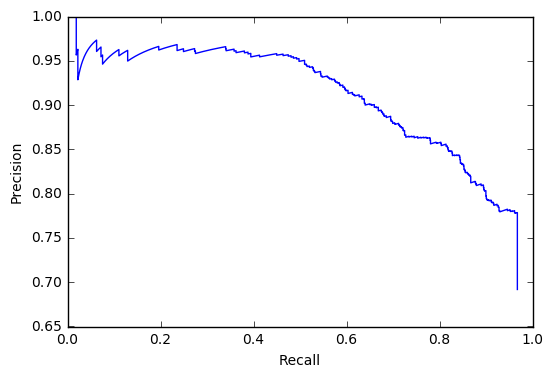

In [38]:
recall_set=[]
precision_set=[]
for number in range(1,len(y_test)):
    precision, recall = percentages(number)
    recall_set.append(recall)
    precision_set.append(precision)
plt.plot(recall_set,precision_set)
plt.show()
plt.xlabel(u'Recall')
plt.ylabel(u'Precision')